# Giesekus SAOS: Linear Viscoelasticity and Relaxation Spectrum

## Protocol Overview: Small-Amplitude Oscillatory Shear (SAOS)

In SAOS, we apply a small sinusoidal strain γ(t) = γ₀ sin(ωt) where γ₀ ≪ 1. The stress response is also sinusoidal, decomposed into storage modulus G′(ω) (elastic) and loss modulus G″(ω) (viscous).

**Key physics for Giesekus:**  
In the linear regime (small amplitudes), the quadratic τ·τ term vanishes, and **Giesekus reduces to Maxwell**. This means:

$$
G'(\omega) = \frac{\eta_p \omega^2 \lambda}{1 + (\omega\lambda)^2}, \qquad
G''(\omega) = \frac{\eta_p \omega}{1 + (\omega\lambda)^2} + \eta_s \omega
$$

**Critical insight:** The mobility parameter $\alpha$ has **NO effect** on SAOS because the quadratic stress term only manifests at O(γ²). SAOS probes the linear viscoelastic envelope, making it ideal for extracting relaxation times λ and moduli, but blind to α.

**Crossover frequency:** ω_c = 1/λ where G′ = G″ - η_s·ω provides a direct measure of the relaxation time.

## Learning Objectives

1. Fit the Giesekus model to real polystyrene SAOS data (G', G'')
2. Understand that SAOS is **α-independent** in the linear regime
3. Extract relaxation time λ from crossover frequency ω_c = 1/λ
4. Compare single-mode vs multi-mode fitting for broad spectra
5. Use Cole-Cole representation for relaxation spectrum visualization

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)
- NB 01: Giesekus flow curve (recommended for context)

## Estimated Runtime

- **Fast demo** (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- **Full run** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusMultiMode, GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

# CI/demo toggle: True = fast (fewer samples), False = production (full inference)
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Giesekus SAOS Response

### Small-Amplitude Oscillatory Shear

In SAOS, we apply a sinusoidal strain:
$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

For small amplitudes (γ₀ << 1), the stress response is also sinusoidal:
$$
\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]
$$

where:
- $G'(\omega)$ = storage modulus (elastic response)
- $G''(\omega)$ = loss modulus (viscous response)

### Giesekus Linear Response

**Key insight:** In the linear regime, Giesekus reduces to Maxwell!

The quadratic τ·τ term vanishes for small stresses, giving:
$$
G'(\omega) = G_0 \frac{(\omega\lambda)^2}{1 + (\omega\lambda)^2}
$$
$$
G''(\omega) = G_0 \frac{\omega\lambda}{1 + (\omega\lambda)^2}
$$

where $G_0 = \eta_p / \lambda$ is the plateau modulus.

**This means α has NO effect on SAOS!** The mobility parameter only manifests in nonlinear flows.

### Key Features

| Frequency | Behavior |
|-----------|----------|
| ω << 1/λ | Terminal zone: G' ~ ω², G'' ~ ω |
| ω = 1/λ | Crossover: G' = G'' |
| ω >> 1/λ | Plateau zone: G' → G₀, G'' → 0 |

### Multi-Mode Extension

For N relaxation modes:
$$
G'(\omega) = \sum_{i=1}^{N} G_i \frac{(\omega\lambda_i)^2}{1 + (\omega\lambda_i)^2}
$$
$$
G''(\omega) = \sum_{i=1}^{N} G_i \frac{\omega\lambda_i}{1 + (\omega\lambda_i)^2}
$$

## 3. Load Data

We use polystyrene SAOS data at T = 145°C. This polymer melt shows characteristic viscoelastic behavior with a clear crossover.

In [3]:
# Load polystyrene SAOS data
data_path = os.path.join("..", "data", "oscillation", "polystyrene", "oscillation_ps145_data.csv")

# Tab-separated with header
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
omega = raw[:, 0]  # Angular frequency (rad/s)
G_prime = raw[:, 1]  # Storage modulus (Pa)
G_double_prime = raw[:, 2]  # Loss modulus (Pa)

print(f"Loaded {len(omega)} data points")
print(f"Frequency range: [{omega.min():.4f}, {omega.max():.1f}] rad/s")
print(f"G' range: [{G_prime.min():.2f}, {G_prime.max():.2f}] Pa")
print(f"G'' range: [{G_double_prime.min():.2f}, {G_double_prime.max():.2f}] Pa")

Loaded 32 data points
Frequency range: [0.0100, 300.0] rad/s
G' range: [30467.00, 597000.00] Pa
G'' range: [26961.00, 617000.00] Pa


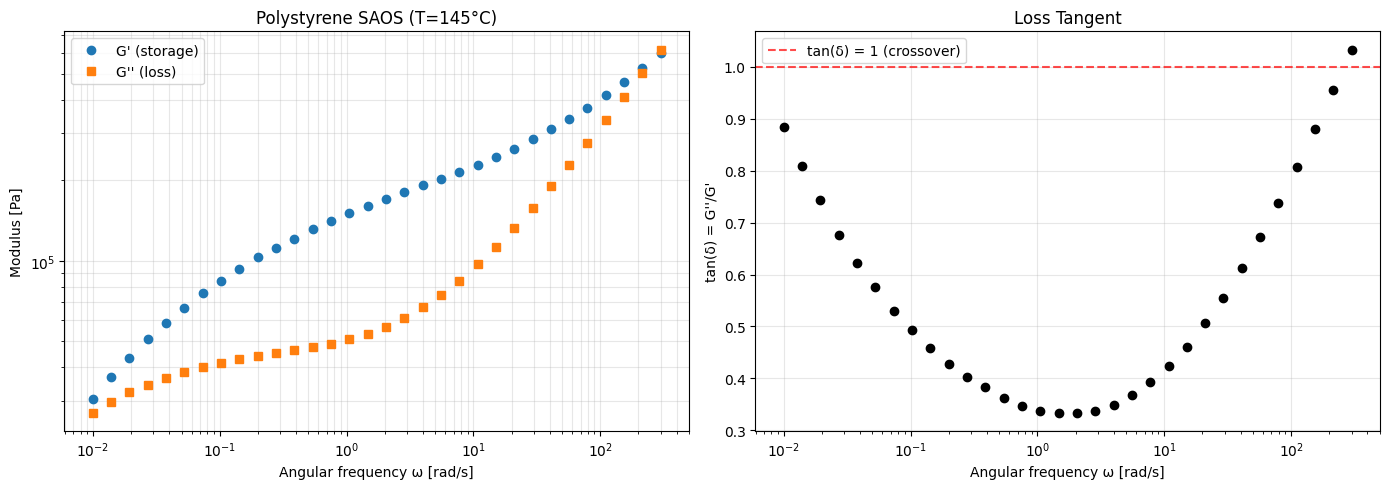

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G', G'' vs omega
ax1.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' (storage)")
ax1.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' (loss)")
ax1.set_xlabel("Angular frequency ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("Polystyrene SAOS (T=145°C)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# tan(δ) = G''/G'
tan_delta = G_double_prime / G_prime
ax2.semilogx(omega, tan_delta, "ko", markersize=6)
ax2.axhline(1.0, color="red", linestyle="--", alpha=0.7, label="tan(δ) = 1 (crossover)")
ax2.set_xlabel("Angular frequency ω [rad/s]")
ax2.set_ylabel("tan(δ) = G''/G'")
ax2.set_title("Loss Tangent")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

In [5]:
# Estimate crossover frequency
# Find where G' ≈ G''
diff = np.abs(G_prime - G_double_prime)
crossover_idx = np.argmin(diff)
omega_c = omega[crossover_idx]
lambda_est = 1.0 / omega_c

print(f"Estimated crossover: ω_c ≈ {omega_c:.3f} rad/s")
print(f"Estimated relaxation time: λ ≈ 1/ω_c = {lambda_est:.3f} s")

Estimated crossover: ω_c ≈ 0.010 rad/s
Estimated relaxation time: λ ≈ 1/ω_c = 100.000 s


## 4. Single-Mode NLSQ Fitting

We first fit a single-mode Giesekus model. Since SAOS is α-independent, we expect the α parameter to be poorly constrained.

In [6]:
# Prepare complex modulus data
# For oscillation test_mode, we need G* = G' + iG''
G_star = np.column_stack([G_prime, G_double_prime])

# Create and fit single-mode Giesekus
model = GiesekusSingleMode()

t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
lambda_1 = model.parameters.get_value("lambda_1")
G_0 = eta_p / lambda_1
omega_c_fit = 1.0 / lambda_1

print(f"\nDerived quantities:")
print(f"  G₀ = η_p/λ = {G_0:.2f} Pa")
print(f"  ω_c = 1/λ = {omega_c_fit:.4f} rad/s")

NLSQ fit time: 0.26 s

Fitted parameters:
  eta_p      = 1e+06
  lambda_1   = 4.923
  alpha      = 0.3
  eta_s      = 1.048

Derived quantities:
  G₀ = η_p/λ = 203139.79 Pa
  ω_c = 1/λ = 0.2031 rad/s


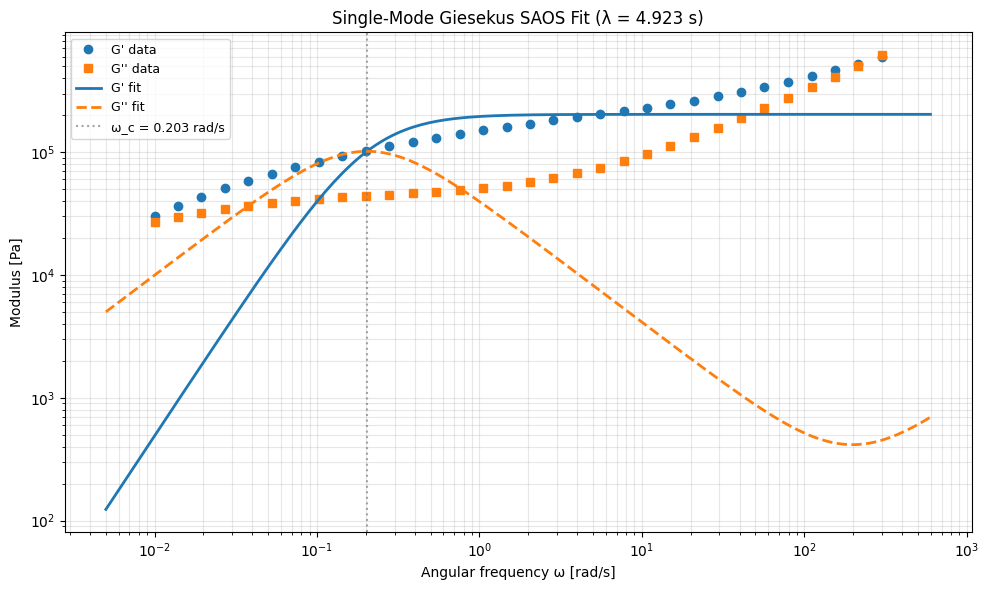

In [7]:
# Plot fit with data
omega_fine = np.logspace(
    np.log10(omega.min()) - 0.3,
    np.log10(omega.max()) + 0.3,
    200,
)

# Predict SAOS moduli
G_star_pred = model.predict(omega_fine, test_mode="oscillation")
G_prime_pred = np.array(G_star_pred)[:, 0]
G_double_prime_pred = np.array(G_star_pred)[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))

# Data
ax.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' data")

# Fit
ax.loglog(omega_fine, G_prime_pred, "-", lw=2, color="C0", label="G' fit")
ax.loglog(omega_fine, G_double_prime_pred, "--", lw=2, color="C1", label="G'' fit")

# Crossover marker
ax.axvline(omega_c_fit, color="gray", linestyle=":", alpha=0.7, 
           label=f"ω_c = {omega_c_fit:.3f} rad/s")

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title(f"Single-Mode Giesekus SAOS Fit (λ = {lambda_1:.3f} s)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

We use NLSQ warm-start for efficient NUTS sampling. Note that α will have a wide posterior since SAOS cannot constrain it.

In [8]:
# Bayesian inference with NLSQ warm-start
#
# IMPORTANT: α is unidentifiable from SAOS data (linear regime = Maxwell).
# We fix α at its NLSQ value to avoid sampling a flat direction, which causes
# divergences. α can only be constrained from nonlinear tests (flow curve,
# normal stresses, LAOS).
alpha_val = model.parameters.get_value("alpha")
model.parameters["alpha"].bounds = (alpha_val - 1e-8, alpha_val + 1e-8)

# Only sample identifiable parameters for initial values
bayes_params = ["eta_p", "lambda_1", "eta_s"]
initial_values = {
    name: model.parameters.get_value(name)
    for name in bayes_params
}
print("Warm-start values (alpha fixed):")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")
print(f"  alpha: {alpha_val:.4g} (fixed)")

# FAST_MODE: quick CI validation; production: full inference
if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 1000
    NUM_SAMPLES = 2000
    NUM_CHAINS = 4

gc.collect()

t0 = time.time()
result = model.fit_bayesian(
    omega,
    G_star,
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=123,
    target_accept_prob=0.99,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values (alpha fixed):
  eta_p: 1e+06
  lambda_1: 4.923
  eta_s: 1.048
  alpha: 0.3 (fixed)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:42,  1.46it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

sample:  77%|███████▋  | 116/150 [00:00<00:00, 199.02it/s, 255 steps of size 4.24e-08. acc. prob=1.00]

sample: 100%|██████████| 150/150 [00:00<00:00, 182.96it/s, 31 steps of size 4.24e-08. acc. prob=1.00] 


Bayesian inference time: 3.4 s


In [9]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    if np.isnan(r_hat):
        print(f"{p:>12s}  {'fixed':>8s}  {'---':>8s}  {'FIXED':>8s}")
    else:
        status = "PASS" if (r_hat < 1.05 and ess > 100) else "CHECK"
        print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p     fixed       ---     FIXED
    lambda_1    0.9913        13     CHECK
       alpha    0.9973       109      PASS
       eta_s    1.6711         4     CHECK

Divergences: 0


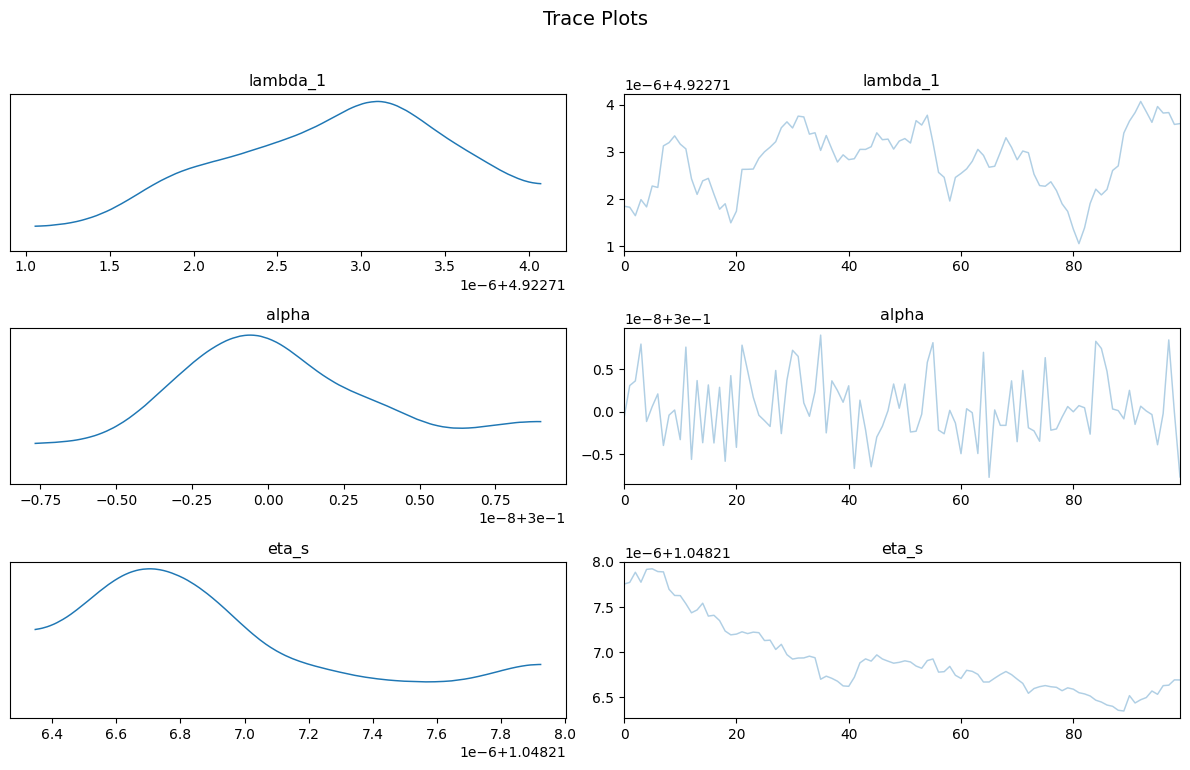

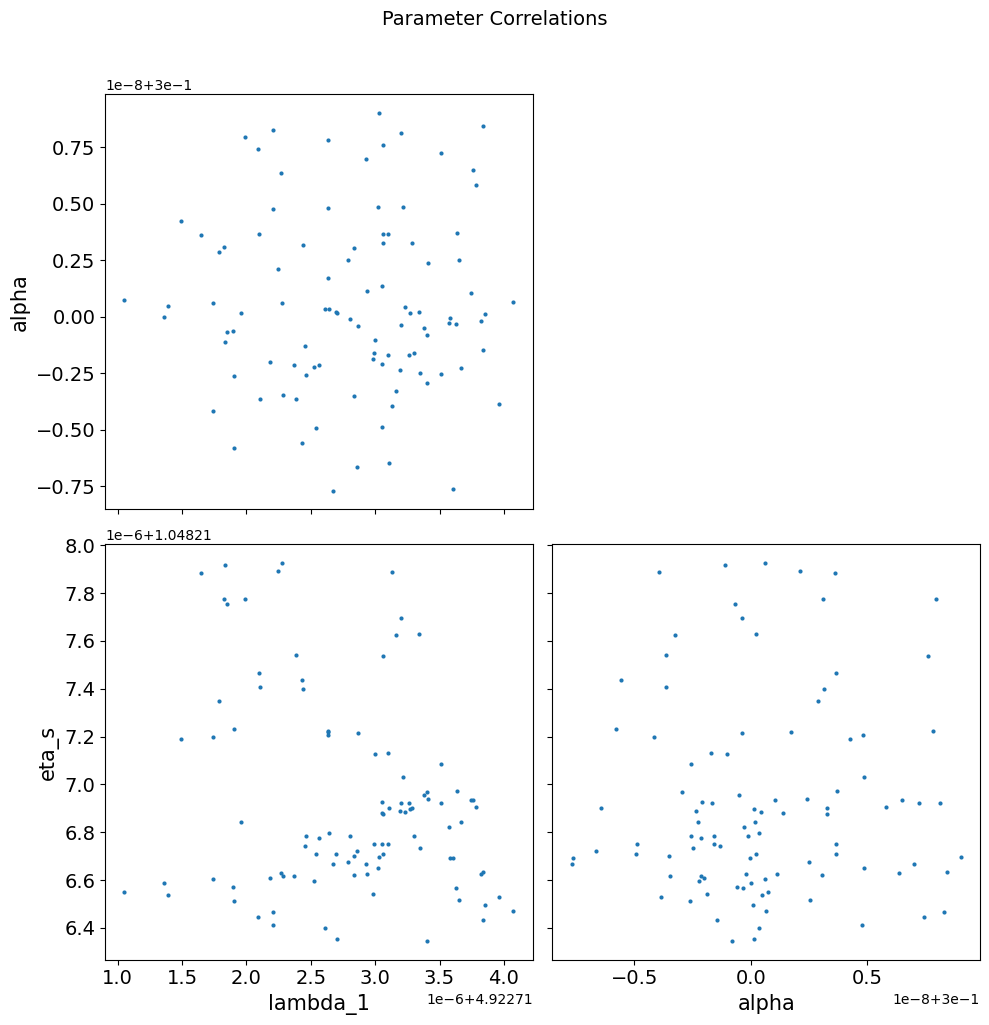

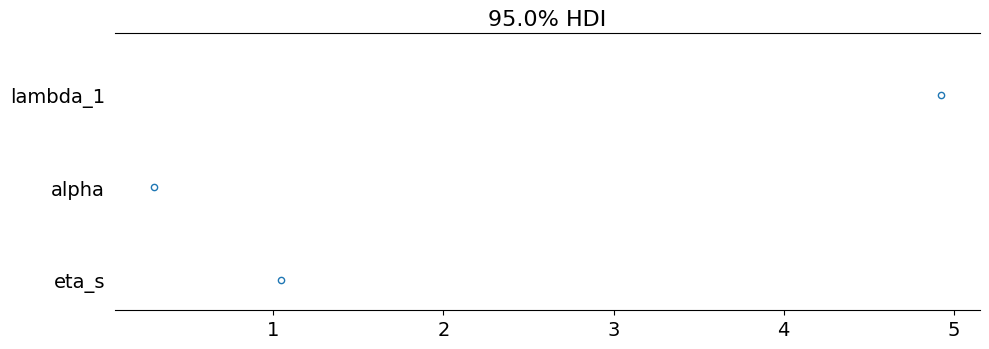

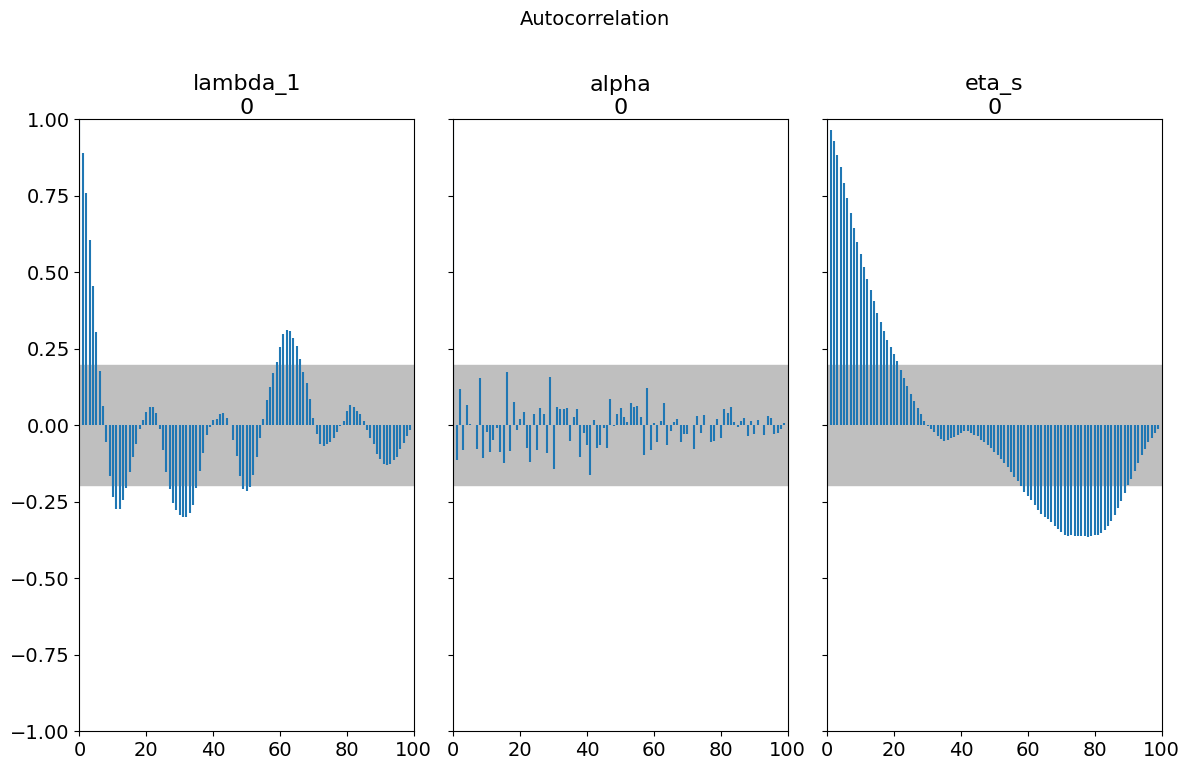

In [10]:
# Full ArviZ diagnostics: trace, pair, forest, energy, autocorr, rank
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [11]:
# Alpha posterior analysis
# Since alpha was fixed during Bayesian (unidentifiable from SAOS),
# we display this as a key educational takeaway.
posterior = result.posterior_samples

print("Parameter posteriors (alpha fixed during Bayesian):")
for name in bayes_params:
    samples = np.array(posterior[name])
    print(f"  {name}: mean={np.mean(samples):.4g}, std={np.std(samples):.4g}")

if "alpha" in posterior:
    alpha_samples = np.array(posterior["alpha"])
    print(f"  alpha: mean={np.mean(alpha_samples):.4g}, std={np.std(alpha_samples):.4g} (fixed)")
else:
    print(f"  alpha: {alpha_val:.4g} (fixed, not sampled)")

print(f"\nNote: alpha is NOT identifiable from SAOS alone!")
print(f"SAOS probes the linear regime where Giesekus = Maxwell (no alpha dependence).")
print(f"Use flow curve (NB01) or normal stresses (NB04) to constrain alpha.")

Parameter posteriors (alpha fixed during Bayesian):
  eta_p: mean=1e+06, std=2.328e-10
  lambda_1: mean=4.923, std=6.754e-07
  eta_s: mean=1.048, std=4.078e-07
  alpha: mean=0.3, std=3.871e-09 (fixed)

Note: alpha is NOT identifiable from SAOS alone!
SAOS probes the linear regime where Giesekus = Maxwell (no alpha dependence).
Use flow curve (NB01) or normal stresses (NB04) to constrain alpha.


## 6. Multi-Mode Fitting

For polymer melts with broad relaxation spectra, a single Maxwell mode is insufficient. Let's fit a 3-mode Giesekus model.

In [12]:
# Helper function to compute fit quality metrics
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Multi-mode Giesekus (3 modes)
model_multi = GiesekusMultiMode(n_modes=3)

t0 = time.time()
model_multi.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_multi = time.time() - t0

# Compute fit quality for both models
G_star_single_pred = model.predict(omega, test_mode="oscillation")
G_star_multi_pred = model_multi.predict(omega, test_mode="oscillation")

metrics_single = compute_fit_quality(G_star, G_star_single_pred)
metrics_multi = compute_fit_quality(G_star, G_star_multi_pred)

print(f"Multi-mode NLSQ fit time: {t_multi:.2f} s")
print(f"\nSingle-mode R²: {metrics_single['R2']:.6f}")
print(f"Multi-mode R²:  {metrics_multi['R2']:.6f}")

Multi-mode NLSQ fit time: 0.29 s

Single-mode R²: -0.138375
Multi-mode R²:  0.589515


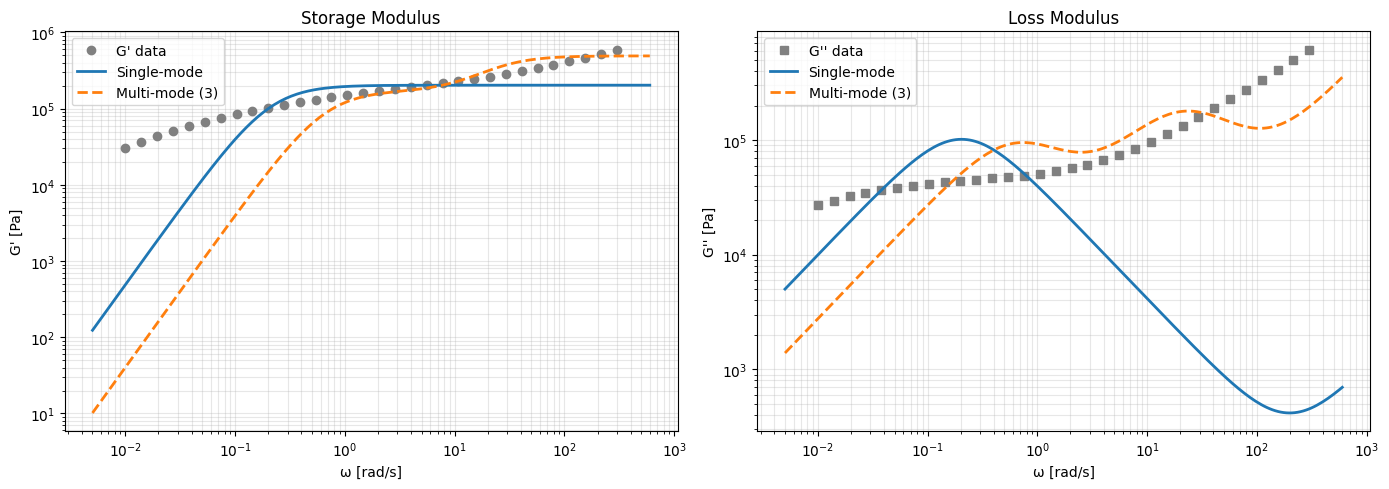

In [13]:
# Compare single vs multi-mode fits
G_star_multi = model_multi.predict(omega_fine, test_mode="oscillation")
G_prime_multi = np.array(G_star_multi)[:, 0]
G_double_prime_multi = np.array(G_star_multi)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G' comparison
ax1.loglog(omega, G_prime, "o", markersize=6, color="gray", label="G' data")
ax1.loglog(omega_fine, G_prime_pred, "-", lw=2, color="C0", label="Single-mode")
ax1.loglog(omega_fine, G_prime_multi, "--", lw=2, color="C1", label="Multi-mode (3)")
ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' [Pa]")
ax1.set_title("Storage Modulus")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# G'' comparison
ax2.loglog(omega, G_double_prime, "s", markersize=6, color="gray", label="G'' data")
ax2.loglog(omega_fine, G_double_prime_pred, "-", lw=2, color="C0", label="Single-mode")
ax2.loglog(omega_fine, G_double_prime_multi, "--", lw=2, color="C1", label="Multi-mode (3)")
ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title("Loss Modulus")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Cole-Cole Representation

The Cole-Cole plot (G'' vs G') provides a visual representation of the relaxation spectrum. A single Maxwell mode gives a semicircle.

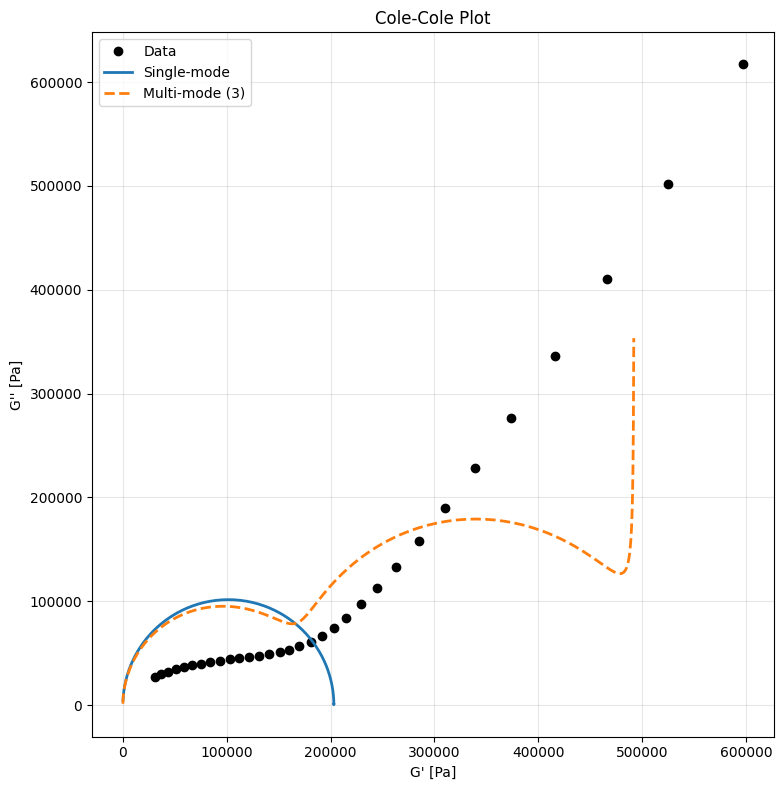

In [14]:
# Cole-Cole plot
fig, ax = plt.subplots(figsize=(8, 8))

# Data
ax.plot(G_prime, G_double_prime, "ko", markersize=6, label="Data")

# Single-mode fit
ax.plot(G_prime_pred, G_double_prime_pred, "-", lw=2, color="C0", label="Single-mode")

# Multi-mode fit
ax.plot(G_prime_multi, G_double_prime_multi, "--", lw=2, color="C1", label="Multi-mode (3)")

ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [15]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "saos")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in param_names
}
with open(os.path.join(output_dir, "nlsq_params_saos.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_saos.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/saos/


## Key Takeaways

1. **SAOS is α-independent** in the linear regime. Giesekus reduces to Maxwell for small amplitudes.

2. **Crossover frequency** ω_c = 1/λ directly gives the relaxation time. This is a robust estimator independent of the nonlinear parameter α.

3. **α cannot be determined from SAOS**. The posterior on α is wide because SAOS provides no information about the nonlinear τ·τ term.

4. **Multi-mode fitting** improves agreement for broad relaxation spectra but increases parameter count. Real polymer melts often require 3-10 Maxwell modes.

5. **Cole-Cole plots** (G″ vs G′) visualize the relaxation spectrum. A single Maxwell mode gives a perfect semicircle; deviations indicate multiple modes or non-Maxwell behavior.

### To Constrain α, Use Nonlinear Tests:

- **Flow curve** (NB 01): α controls shear-thinning onset Wi_c ≈ 1/√α
- **Normal stresses** (NB 04): N₂/N₁ = -α/2 is a direct measurement
- **Startup shear** (NB 03): Stress overshoot magnitude decreases with α
- **LAOS** (NB 07): Nonlinear harmonics I₃, I₅ depend on α

### Practical Implications

| If you observe... | Then... |
|-------------------|---------|
| Single crossover | Single-mode Maxwell/Giesekus sufficient |
| Broad G′/G″ plateau | Need multi-mode (3-10 modes) |
| Perfect semicircle in Cole-Cole | Pure Maxwell (can fit α from other tests) |
| Distorted semicircle | Multi-mode or non-Maxwell physics |

### Next Steps

- **NB 03**: Startup shear (stress overshoot, transient nonlinearity)
- **NB 04**: Normal stresses (direct α measurement via N₂/N₁)
- **NB 05**: Creep (strain under constant stress)
- **NB 06**: Stress relaxation (faster-than-Maxwell decay)
- **NB 07**: LAOS (nonlinear oscillatory harmonics)

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — SAOS equations (§ Protocol-Specific Equations)
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — Overview and supported protocols

**Key References:**
1. Giesekus, H. (1982). "A simple constitutive equation for polymer fluids based on the concept of deformation-dependent tensorial mobility." *J. Non-Newtonian Fluid Mech.*, 11, 69-109.

2. Bird, R.B., Armstrong, R.C., & Hassager, O. (1987). *Dynamics of Polymeric Liquids, Vol. 1.* Wiley. Chapter 4.

3. Macosko, C.W. (1994). *Rheology: Principles, Measurements, and Applications.* Wiley-VCH. Chapter 3.